# SMAP data processing demonstration
The below script provides examples on how to:
1. ### Read in SMAP data and navigate metadata
2. ### Create a map with SMAP data
3. ### Plot a time-series at a location on Earth

The complementary <b><i>1.0 Access SMAP data</i></b> script provided demonstrates where and how to obtain SMAP data from the [NSIDC data portal](https://n5eil01u.ecs.nsidc.org/SMAP/) via [WGET](https://www.gnu.org/software/wget/) and [OPENDAP](https://www.opendap.org).

#### Import packages

In [1]:
import datetime as dt
import glob
import h5py
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import numpy as np
import os
import pandas as pd
import xarray as xr
home_dir = os.getcwd(); #<--- we are going to use this to navigate back to where this script is saved

/home/trst2284/miniconda3/envs/smap/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/trst2284/miniconda3/envs/smap/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


## 1. Read SMAP data and navigate metadata
* First we navigate to the folder with the data we want to use for this quick demo. 
* Next lets make a list of the files within the folder and print one out.

In [2]:
os.chdir('Data/L3_SM_P/')
L3_SM_P_dir = os.getcwd();
print("Current working directory:\t" + L3_SM_P_dir +"\n")
flist = glob.glob('*.h5')
filename = flist[0]; 
print("File we are using:\t\t" +filename + '\n')

Current working directory:	/home/trst2284/code/smap_python_tutorial/Data/L3_SM_P

File we are using:		SMAP_L3_SM_P_20170307_R14010_001.h5



*  Now lets use h5py.File() to open the file
*  Then we can look at the folders within the file to access the data we want

In [3]:
f = h5py.File(filename, 'r')
print('By using the command h5py.File() a filehandle is returned:')
print(f); print('\n')

print("Now lets look at the groups within the file to access:")
i=0;
for key in f.keys():
    print(str(i)+ '\t'+key)
    i+=1
group_id=list(f.keys())[1];# < Lets focus on the AM overpass for this example
print('\n')
i=0
print("Now lets look at the variables within the filegroup **Soil_Moisture_Retrieval_Data_AM** to access the actual data:")
for var in list(f[group_id].keys()):
    print(str(i)+'\t'+var)
    i+=1

By using the command h5py.File() a filehandle is returned:
<HDF5 file "SMAP_L3_SM_P_20170307_R14010_001.h5" (mode r)>


Now lets look at the groups within the file to access:
0	Metadata
1	Soil_Moisture_Retrieval_Data_AM
2	Soil_Moisture_Retrieval_Data_PM


Now lets look at the variables within the filegroup **Soil_Moisture_Retrieval_Data_AM** to access the actual data:
0	static_water_body_fraction
1	boresight_incidence
2	tb_time_utc
3	vegetation_opacity
4	tb_qual_flag_h
5	roughness_coefficient
6	landcover_class
7	EASE_row_index
8	tb_v_corrected
9	tb_4_corrected
10	longitude_centroid
11	longitude
12	landcover_class_fraction
13	latitude
14	retrieval_qual_flag
15	vegetation_water_content
16	soil_moisture
17	tb_3_corrected
18	tb_qual_flag_3
19	tb_qual_flag_4
20	tb_h_corrected
21	albedo
22	tb_time_seconds
23	soil_moisture_error
24	radar_water_body_fraction
25	tb_qual_flag_v
26	latitude_centroid
27	EASE_column_index
28	surface_temperature
29	freeze_thaw_fraction
30	surface_flag


Ok now that we know the variables within the Soil_Moisture_Retrieval_Data_AM lets take a grab the data we want to make a plot of soil moisture.
* First lets take a look at the shape
    - we will need this later when opening the lat, lon datasets

In [4]:
print('the data has a shape of: '+str(f[group_id][list(f[group_id].keys())[0]].shape))

the data has a shape of: (406, 964)


* Now fill in the below keys from above to get the variables we want to plot.

In [5]:
var_id = list(f[group_id].keys())[16] # soil_moisture
sm_data = f[group_id][var_id][:,:]
sm_ds = f[group_id][var_id]
print('data are returned as '+str(type(sm_data)) + ' something easy to work with in python.')

data are returned as <class 'numpy.ndarray'> something easy to work with in python.


In [6]:
ret_flag_L3_P = f[group_id]['retrieval_qual_flag'][:,:]
print(np.unique(ret_flag_L3_P))
print(type(ret_flag_L3_P))

[ 0  1  5  7  8  9 13 15]
<class 'numpy.ndarray'>


## 2. Create a map with SMAP data
* Lets plot the data to get a sense of what we are working with

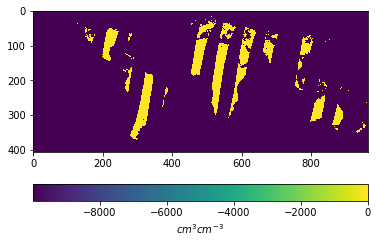

In [7]:
plt.imshow(sm_data)
cbar = plt.colorbar(orientation = 'horizontal')
cbar.set_label('$cm^3 cm^{-3}$')

Ok we have to ignore the null values to get a better idea of the range in values of the dataset.

You can find these null values in the meta data of the supplemental documents.

We know for soil moisture and most smap datasets it to be -9999.
This is located under the attributes for the 'soil_moisture' variable

In [8]:
print(f[group_id][var_id].attrs['_FillValue'])

-9999.0


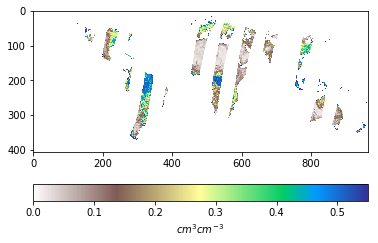

In [9]:
sm_data[sm_data==f[group_id][var_id].attrs['_FillValue']]=np.nan;
plt.imshow(sm_data,vmin=0.,vmax=0.55, cmap = 'terrain_r');
cbar = plt.colorbar(orientation='horizontal')
cbar.set_label('$cm^3 cm^{-3}$')

How about we spruce this up with some coastlines, and geolocate the data using the lat, lon data?

Below we load the EASE2 grid lon and lat datasets.  These can be found on the NSIDC website.

In [10]:
# Lets grab the lat and lon data so we navigate to the directory
os.chdir(home_dir)
# Read binary files and reshape to correct size
lats = np.fromfile('EASE2_M36km.lats.964x406x1.double', 
                      dtype=np.float64).reshape((406,964))#< reshape to dimensions above
lons = np.fromfile('EASE2_M36km.lons.964x406x1.double', 
                      dtype=np.float64).reshape((406,964))

Now lets use basemap to plot the dataset

There are many online tutorials for basemap, to focus in on a region, and it provides lots of ways to display the data.

/home/trst2284/miniconda3/envs/smap/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1712: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  if limb is not ax.axesPatch:


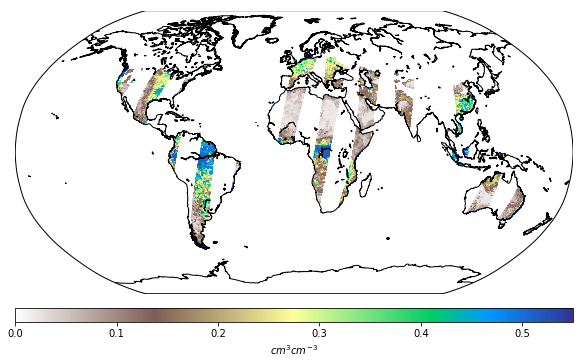

In [11]:
fig = plt.figure(figsize=(10,6))
m = Basemap(resolution='l',projection='robin',lat_ts=40,lat_0=lats.mean(),lon_0=lons.mean())
xi, yi = m(lons, lats)
cs = m.pcolor(xi,yi,sm_data, vmin = 0., vmax = 0.55, cmap = 'terrain_r')
m.drawcoastlines()
cbar = m.colorbar(cs, location='bottom', pad="5%")
cbar.set_label('$cm^3 cm^{-3}$')

Awesome! We now can make a global plot, lets see if we can make this a bit more streamlined to process more data and create a time series.

## 3. Plot a time-series at a location on Earth
* Lets stick with the L3 SM P dataset because the data isnt that big and its what I could put on your flashdrives for the demo.

Lets start by navigating back to the L3_SM_P directory & creating a filelist and a make a 3-d array to work wiht

In [12]:
os.chdir(L3_SM_P_dir)
print("Current working directory:\t" + L3_SM_P_dir +"\n")
print('Files in Directory:')
flist = glob.glob('*.h5')
for fName in flist:
    print(fName)

Current working directory:	/home/trst2284/code/smap_python_tutorial/Data/L3_SM_P

Files in Directory:
SMAP_L3_SM_P_20170307_R14010_001.h5
SMAP_L3_SM_P_20170331_R14010_001.h5
SMAP_L3_SM_P_20170322_R14010_001.h5
SMAP_L3_SM_P_20170304_R14010_001.h5
SMAP_L3_SM_P_20170315_R14010_001.h5
SMAP_L3_SM_P_20170302_R14010_001.h5
SMAP_L3_SM_P_20170313_R14010_001.h5
SMAP_L3_SM_P_20170306_R14010_001.h5
SMAP_L3_SM_P_20170311_R14010_001.h5
SMAP_L3_SM_P_20170321_R14010_001.h5
SMAP_L3_SM_P_20170314_R14010_001.h5
SMAP_L3_SM_P_20170324_R14010_001.h5
SMAP_L3_SM_P_20170318_R14010_001.h5
SMAP_L3_SM_P_20170328_R14010_001.h5
SMAP_L3_SM_P_20170329_R14010_001.h5
SMAP_L3_SM_P_20170310_R14010_001.h5
SMAP_L3_SM_P_20170309_R14010_001.h5
SMAP_L3_SM_P_20170301_R14010_001.h5
SMAP_L3_SM_P_20170316_R14010_001.h5
SMAP_L3_SM_P_20170319_R14010_001.h5
SMAP_L3_SM_P_20170326_R14010_001.h5
SMAP_L3_SM_P_20170317_R14010_001.h5
SMAP_L3_SM_P_20170323_R14010_001.h5
SMAP_L3_SM_P_20170330_R14010_001.h5
SMAP_L3_SM_P_20170303_R14010_001.h

* Lets make a function to load some data.



In [13]:
def read_SML3P(filename):
    ''' This function extracts lat, lon and soil moisture from SMAP L3 P HDF5 file.
    Filename is th efilename
    
    Parameters
    ----------
    filename : str
        File path of a SMAP L3 HDF5 file
    Returns
    -------
    soil_moisture_am: numpy.array
        A 2-D array of 
    '''    
    with h5py.File(filename, 'r') as f:
        # Extract data info
        group_id_am = 'Soil_Moisture_Retrieval_Data_AM'
        var_id_am = 'soil_moisture'
        flag_id_am = 'retrieval_qual_flag'
        soil_moisture_am = f[group_id_am][var_id_am][:,:]
        flag_am = f[group_id_am][flag_id_am][:,:]
        soil_moisture_am[soil_moisture_am==-9999.0]=np.nan;
        soil_moisture_am[(flag_am>>0)&1==1]=np.nan
        yyyymmdd= filename.split('_')[4]
        yyyy = int(yyyymmdd[0:4]);        mm = int(yyyymmdd[4:6]);        dd = int(yyyymmdd[6:8])
        date=dt.datetime(yyyy,mm,dd)
    return soil_moisture_am,date

* Lets check if it works:

Text(0.5,1,'2017-03-07 00:00:00')

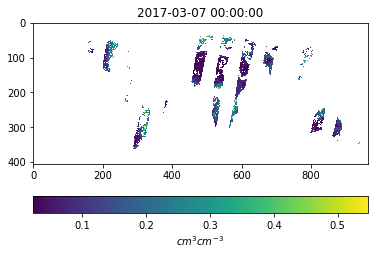

In [14]:
sm_test,date = read_SML3P(flist[0])
plt.imshow(sm_test)
cbar = plt.colorbar(orientation='horizontal')
cbar.set_label('$cm^3 cm^{-3}$')
plt.title(date)

* Now that we have that working lets add everything to a 3-d array, remember time is the 3rd dimension
* For larger datasets (i.e. 3km data or even 9km data you need to get creative to do on your local machine)

In [15]:
sm_data_3d = np.empty([sm_data.shape[0],sm_data.shape[1],len(flist)])
times = []
print('sm_data_3d has dimensions '+str(sm_data_3d.shape))
i=0
for fName in flist:
    sm_data_3d[:,:,i],time_i = read_SML3P(fName)
    times.append(time_i)
    i+=1

sm_data_3d has dimensions (406, 964, 31)


/home/trst2284/miniconda3/envs/smap/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: Mean of empty slice
  """Entry point for launching an IPython kernel.


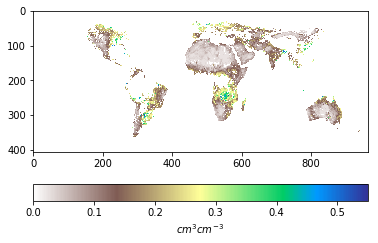

In [16]:
sm_mean = np.nanmean(sm_data_3d,2)
sm_mean.shape
plt.imshow(sm_mean,vmin=0.,vmax=0.55,cmap='terrain_r')
cbar = plt.colorbar(orientation='horizontal')
cbar.set_label('$cm^3 cm^{-3}$')

/home/trst2284/miniconda3/envs/smap/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: Mean of empty slice
  # Remove the CWD from sys.path while we load stuff.


Text(0.5,1,'Soil Moisture')

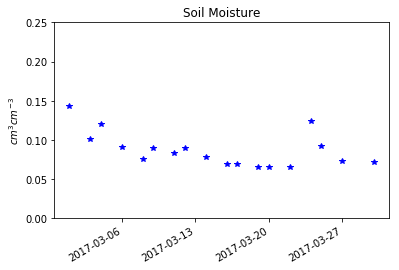

In [17]:
N_lat = 37.5; 
S_lat = 33
W_lon = -113.5
E_lon = -110.0

subset = (lats<N_lat)&(lats>S_lat)&(lons>W_lon)&(lons<E_lon);
sm_time = np.empty([len(flist)]);
for i in np.arange(0,sm_data_3d.shape[2]):
    sm_2d = sm_data_3d[:,:,i]
    sm_time[i] = np.nanmean(sm_2d[subset]); 

# Lets create a pandas series to plot the data
smData = {'sm':sm_time}
sm = pd.DataFrame(smData)
sm['time']=times
sm=sm.set_index('time')

fig, ax1 = plt.subplots()
ax1.plot(sm.index, sm, 'b*')       
ax1.set_ylim([0,0.25])
fig.autofmt_xdate()
ax1.set_ylabel('$cm^3 cm^{-3}$')
plt.title('Soil Moisture')